In [ ]:
!pip install spectral
!pip install tensorflow-addons

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import L2, L1
from tensorflow import one_hot as to_categorical
import tensorflow_addons as tfa

import numpy as np

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, accuracy_score
from sklearn import preprocessing

import random
from random import shuffle

import os

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

from IPython.core.pylabtools import figsize

import scipy

import spectral

import scipy.io as sio

import time

import math

import collections

In [ ]:
!nvidia-smi 

Fri Apr 22 06:25:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
windowSize = 9
testRatio = 0.9
valRatio = 0.1

In [ ]:
def loadSalinasData():
    data = sio.loadmat(r'Salinas_corrected.mat')['salinas_corrected']
    labels = sio.loadmat(r'Salinas_gt.mat')['salinas_gt']
    return data, labels

In [ ]:
X, y = loadSalinasData()
print ("Shape of X : "+str(X.shape))
print ("Shape of y : "+str(y.shape))

Shape of X : (512, 217, 204)
Shape of y : (512, 217)


In [ ]:
#For plotting accuracy plots
y_accuracy_plot = y

In [ ]:
#Function to plot HSI data and the groundtruths together
def plot_data_and_gt(X, y):
  
  labels = ['Background', 'Brocoli_green_weeds_1', 'Brocoli_green_weeds_2', 'Fallow', 'Fallow_rough_plow', 'Fallow_smooth', 'Stubble', 'Celery', 'Grapes_untrained', 'Soil_vineyard_develop', 'Corn_senesced_green_weeds', 'Lettuce_romaine_4wk', 'Lettuce_romaine_5wk', 'Lettuce_romaine_6wk', 'Lettuce_romaine_7wk', 'Vineyard_untrained', 'Vineyard_vertical_trellis']
  i=0
  #Value of cmap can also be changed to gist_ncar. Try it out. However, if all the classes have to been clearly, nipy_spectral_r seems better.
  cmap = cm.nipy_spectral_r
  unique_data = np.unique(y)
  unique_data = unique_data/np.max(unique_data)
  #Specifying cmap color for all the groundtruth values
  for entry in unique_data:
    mycolor = cmap(entry)
    plt.plot(0, 0, "-", color=mycolor, label=labels[i], linewidth=5)
    i += 1
  
  plt.imshow(y, cmap=cmap)
  plt.legend(loc="upper right", bbox_to_anchor=(3.5, 1.0))
  plt.axis('off')
  plt.show()
  
  #Plotting spectral input data
  spectralimage_data = spectral.imshow(X, figsize =(4,4))
  
  #This is another way to plot the groundtruth image but isn't required currently.
  #spectralimage_gt = spectral.imshow(classes = y.astype(int), figsize=(4,4))

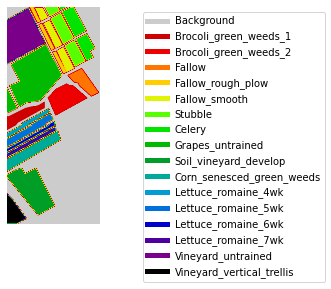

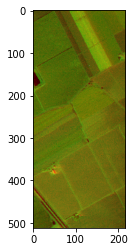

In [ ]:
plot_data_and_gt(X, y)

In [ ]:
def standartizeData(X):
  #Standardize data to have 0 mean and 1 variance
  newX = np.reshape(X, (-1, X.shape[2]))
  scaler = preprocessing.StandardScaler()  
  newX = scaler.fit_transform(newX)
  newX = np.reshape(newX, (X.shape[0],X.shape[1],X.shape[2]))
  return newX, scaler

In [ ]:
X, scaler = standartizeData(X)
print ("Shape of X : "+str(X.shape))

Shape of X : (512, 217, 204)


In [ ]:
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    print (f"The explained variance ratio for {numComponents} components is "+str(pca.explained_variance_ratio_))
    print (f"The total amount of data restored in {numComponents} components of PCA is "+str(np.sum(pca.explained_variance_ratio_)*100)+"%")
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
X, pca = applyPCA(X, numComponents=10)
print ("Shape of X after PCA : "+str(X.shape))

The explained variance ratio for 10 components is [0.66299056 0.275551   0.02247438 0.0153391  0.00839933 0.00460708
 0.00235803 0.00196938 0.00159594 0.00096683]
The total amount of data restored in 10 components of PCA is 99.62516340768997%
Shape of X after PCA : (512, 217, 10)


In [ ]:
#Plotting the accuracy plots
X_accuracy_plot = X

In [ ]:
#Function to pad the input data with zeros
def padXWithZeros(X, margin=2):
  newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
  x_offset = margin
  y_offset = margin
  newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
  return newX

def padYWithZeros(Y, margin=2):
  newY = np.full((Y.shape[0] + 2 * margin, Y.shape[1] + 2* margin),-1)
  #newY = np.zeros((Y.shape[0] + 2 * margin, Y.shape[1] + 2* margin))
  x_offset = margin
  y_offset = margin
  newY[x_offset:Y.shape[0] + x_offset, y_offset:Y.shape[1] + y_offset] = Y
  return newY

#Function to create patches after the input data has been padded with zeros on the edges
def createPatches(X, y, windowSize=windowSize, removeZeroLabels = True):
  #print ("Shape of X : "+str(X.shape))
  #print ("Shape of y : "+str(y.shape))
  margin = int((windowSize - 1) / 2)
  zeroPaddedX = padXWithZeros(X, margin=margin)
  zeroPaddedY = padYWithZeros(y, margin=margin)
  # split patches
  patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
  #print (f"patches data all zeros : {str(patchesData.shape)}")
  patchesY = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize))
  #print (f"patches Y all zeros : {str(patchesY.shape)}")
  patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
  #print (f"patches labels all zeros: {str(patchesLabels.shape)}")
  patchIndex = 0
  # Done until here
  for r in range(margin, zeroPaddedX.shape[0] - margin):
      for c in range(margin, zeroPaddedX.shape[1] - margin):
          patchX = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
          #print (f"patchX shape : {str(patchX.shape)}")
          patchesData[patchIndex, :, :, :] = patchX
          patchY = zeroPaddedY[r - margin:r + margin + 1, c - margin:c + margin + 1]
          #print (f"patchY shape : {str(patchY.shape)}")
          patchesY[patchIndex,:,:] = patchY
          patchesLabels[patchIndex] = y[r-margin, c-margin]
          patchIndex = patchIndex + 1
  if removeZeroLabels:
      patchesData = patchesData[patchesLabels>0,:,:,:]
      patchesY = patchesY[patchesLabels>0,:,:]
      patchesLabels = patchesLabels[patchesLabels>0]
      patchesLabels -= 1
      patchesY -=1
  return patchesData, patchesY, patchesLabels

In [ ]:
X_patches, y_patches, y_labels = createPatches(X, y, windowSize=windowSize)
print ("Shape of X with patches : "+str(X_patches.shape))
print ("Shape of y with patches : "+str(y_patches.shape))
print ("Shape of y : "+str(y_labels.shape))

Shape of X with patches : (54129, 9, 9, 10)
Shape of y with patches : (54129, 9, 9)
Shape of y : (54129,)


In [ ]:
#Just to check if the patch's center pixel actually corresponds to the real label value
i = tf.random.uniform(shape=(), minval=0, maxval=y_labels.shape[0], dtype=tf.int32)
i=10
print (f'This is the random number generated : {i}')
print (f'This is the label patch :\n {y_patches[i]}')
print (f' This is the actual label : {y_labels[i]}')

This is the random number generated : 10
This is the label patch :
 [[-2. -2. -2. -2. -2. -2. -2. -2. -2.]
 [-2. -2. -2. -2. -2. -2. -2. -2. -2.]
 [-2. -2. -2. -2. -2. -2. -2. -2. -2.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.  5.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.  5.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.  5.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.  5.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.  5.]]
 This is the actual label : 5.0


In [ ]:
#This is to denote all the classes that are present in the dataset currently.
# -2 signifies padding
# -1 signifies background pixels
# Numbers 0 to 8 signify the 9 valid classes present in the dataset
np.unique(y_patches)

array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,
       11., 12., 13., 14., 15.])

In [ ]:
def splitTrainTestSet(X, y_labels, testRatio=testRatio):
  X_train, X_test, y_labels_train, y_labels_test = train_test_split(X, y_labels, test_size=testRatio, random_state=345, stratify=y_labels)
  X_val, X_test, y_labels_val, y_labels_test = train_test_split(X_test, y_labels_test, test_size=testRatio/(testRatio + valRatio), random_state=345, stratify=y_labels_test)

  return X_train, X_test, X_val, y_labels_train, y_labels_test, y_labels_val

In [ ]:
X_train, X_test, X_val, y_labels_train, y_labels_test, y_labels_val = splitTrainTestSet(X_patches, y_labels)

print ("Shape of X_train : "+str(X_train.shape))
print ("Shape of X_test : "+str(X_test.shape))
print ("Shape of X_val : "+str(X_val.shape))
print ("Shape of y_labels_train : "+str(y_labels_train.shape))
print ("Shape of y_labels_test : "+str(y_labels_test.shape))
print ("Shape of y_labels_val : "+str(y_labels_val.shape))

Shape of X_train : (5412, 9, 9, 10)
Shape of X_test : (43846, 9, 9, 10)
Shape of X_val : (4871, 9, 9, 10)
Shape of y_labels_train : (5412,)
Shape of y_labels_test : (43846,)
Shape of y_labels_val : (4871,)


In [ ]:
def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY

In [ ]:
#Counting the number of samples in the training set that belongs to a specific class
count = y_labels_train
counter=collections.Counter(count)
print (counter)

Counter({7.0: 1127, 14.0: 727, 8.0: 620, 5.0: 396, 1.0: 372, 6.0: 358, 9.0: 328, 4.0: 268, 0.0: 201, 2.0: 197, 11.0: 193, 15.0: 181, 3.0: 139, 10.0: 107, 13.0: 107, 12.0: 91})


In [ ]:
X_train, y_labels_train = oversampleWeakClasses(X_train, y_labels_train)
print ("Shape of X_train : "+str(X_train.shape))
print ("Shape of X_test : "+str(X_test.shape))
print ("Shape of X_val : "+str(X_val.shape))
print ("Shape of y_labels_train : "+str(y_labels_train.shape))
print ("Shape of y_labels_test : "+str(y_labels_test.shape))
print ("Shape of y_labels_val : "+str(y_labels_val.shape))

Shape of X_train : (18445, 9, 9, 10)
Shape of X_test : (43846, 9, 9, 10)
Shape of X_val : (4871, 9, 9, 10)
Shape of y_labels_train : (18445,)
Shape of y_labels_test : (43846,)
Shape of y_labels_val : (4871,)


In [ ]:
#Counting the number of samples in the training set that belongs to a specific class
count = y_labels_train
counter=collections.Counter(count)
print (counter)

Counter({14.0: 1454, 8.0: 1240, 0.0: 1206, 5.0: 1188, 2.0: 1182, 13.0: 1177, 10.0: 1177, 11.0: 1158, 7.0: 1127, 1.0: 1116, 3.0: 1112, 12.0: 1092, 15.0: 1086, 6.0: 1074, 4.0: 1072, 9.0: 984})


In [ ]:
num_classes = len(np.unique(y_labels_train))
input_shape = X_train[1].shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 100
image_size = len(X_train[1])  # We'll resize input images to this size.In our case, the size of the input image remains the same.
patch_size = 3  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4
mlp_head_units = [2048, 1024, 100]  # Size of the dense layers of the final classifier

In [ ]:
#Implementing the data augmentation layer
data_augmentation = tf.keras.Sequential([
                                         #tf.keras.layers.Normalization(),
                                         tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.RandomFlip("vertical")
], name = 'data_augmentation')

#data_augmentation.layers[0].adapt(X_train)

In [ ]:
#Implementing the multi-layer perceptron
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
      #ADDED KERNEL REGULARIZER HERE BELOW
      #CHANGED ACTIVATION FUNCTION FROM GELU
        x = tf.keras.layers.Dense(units, kernel_regularizer=L2(1e-3), activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
#Implementing patch creation as a layer as a whole by overriding the tf.keras.layers module
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
#Checking if the patch creation layer is working fine for a single image
image = X_train[np.random.choice(range(X_train.shape[0]))]

image = np.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))

patches = Patches(patch_size)(image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

Image size: 9 X 9
Patch size: 3 X 3
Patches per image: 9
Elements per patch: 90


In [ ]:
#Implementing the patch encoding layer
#The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. 
#In addition, it adds a learnable position embedding to the projected vector.
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
#Creating the vision transformer architecture as a method

def create_vit_classifier():
    inputs = tf.keras.layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        #CHANGED EPSILON VALUE BELOW WHICH WAS INITIALLY 1E-6
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = tf.keras.layers.MultiHeadAttention(
            #INCREASED DROPOUT BELOW WHICH WAS ORIGINALLY 0.1
            num_heads=num_heads, key_dim=projection_dim, dropout=0.2
        )(x1, x1)
        # Skip connection 1.
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        #CHANGED EPSILON VALUE BELOW WHICH WAS INITIALLY 1E-6
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        #INCREASED DROPOUT BELOW WHICH WAS ORIGINALLY 0.1
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.2)
        # Skip connection 2.
        encoded_patches = tf.keras.layers.Add()([x3, x2])
        
    # Create a [batch_size, projection_dim] tensor.
    #CHANGED EPSILON VALUE BELOW WHICH WAS INITIALLY 1E-6
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = tf.keras.layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
#Compiling the vision transformer model built
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    start = time.time()

    history = model.fit(
        x=X_train,
        y=y_labels_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data = (X_val, y_labels_val),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_labels_test)
    end = time.time()
    
    total = (end-start)/60

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    print(f"Total time to train and evaluate the model : {str(total)} minutes")


    return history

In [ ]:
#Instantiating the model
vit_classifier = create_vit_classifier()
#vit_classifier.summary()

In [ ]:
#Running the model
history = run_experiment(vit_classifier)

Epoch 1/100
289/289 [==============================] - 32s 57ms/step - loss: 3.2531 - accuracy: 0.8123 - top-5-accuracy: 0.9756 - val_loss: 2.4151 - val_accuracy: 0.7994 - val_top-5-accuracy: 1.0000
Epoch 2/100
289/289 [==============================] - 11s 39ms/step - loss: 1.8005 - accuracy: 0.9205 - top-5-accuracy: 0.9994 - val_loss: 1.4347 - val_accuracy: 0.8567 - val_top-5-accuracy: 1.0000
Epoch 3/100
289/289 [==============================] - 11s 38ms/step - loss: 1.0577 - accuracy: 0.9407 - top-5-accuracy: 0.9993 - val_loss: 1.0885 - val_accuracy: 0.7970 - val_top-5-accuracy: 1.0000
Epoch 4/100
289/289 [==============================] - 11s 39ms/step - loss: 0.6951 - accuracy: 0.9496 - top-5-accuracy: 0.9997 - val_loss: 0.5920 - val_accuracy: 0.9411 - val_top-5-accuracy: 1.0000
Epoch 5/100
289/289 [==============================] - 11s 38ms/step - loss: 0.5033 - accuracy: 0.9579 - top-5-accuracy: 0.9993 - val_loss: 0.5160 - val_accuracy: 0.9103 - val_top-5-accuracy: 1.0000
Epoch

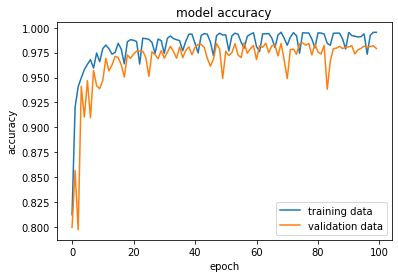

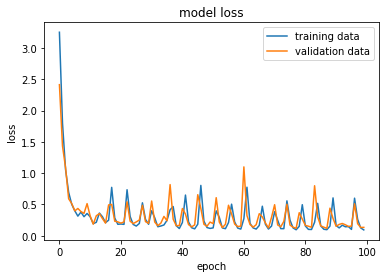

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='upper right')
plt.show()

In [ ]:
def plot_accuracy_map (X, y):
    Xshape = X    
    X, y_patches, y = createPatches(X, y, windowSize=windowSize, removeZeroLabels=False)
    prediction = vit_classifier.predict(X)
    prediction = np.argmax(prediction, axis = 1)
    
    for i in range(0, len(y)):
        if (y[i] == 0):
            y[i] = 0
        elif (y[i] == 16):
            y[i] = 16
        else :
            y[i] = prediction[i]+1
            
    y = y.reshape((Xshape.shape[0], Xshape.shape[1]))
    predict_image = spectral.imshow(classes = y.astype(int),figsize =(5,5))

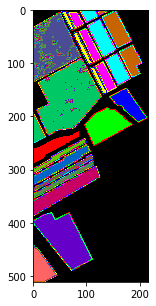

In [ ]:
#Plotting the accuracy map for the proposed approach
plot_accuracy_map(X_accuracy_plot, y_accuracy_plot)

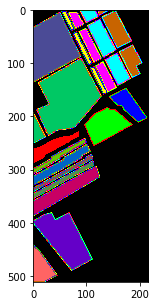

In [ ]:
#Plotting the groundtruth data
predict_image = spectral.imshow(classes = y_accuracy_plot.astype(int),figsize =(5,5))